<img src='images/gdd-logo.png' width='300px' align='right' style="padding: 15px">

# Feature Engineering: An example with bikes

The success of a machine learning algorithm is partly dependent on how you choose to represent the data.  You may have seen this before in practice with **preprocessing techniques** like *one hot encoding your categorical data*, data cleaning (removing or imputing *missing data*), and the effectivness of *scaling/normalizing* your data. 

Feature engineering is the **practice of creating new features** from your **existing** data or **additional** data sources to improve model performance. In this notebook, we will show how to create new features that might improve model performance and discuss common feature engineering practices:

- [About the data](#data)
- [Baseline model](#baseline)
- Feature Engineering
    - [Date Features](#date)
    - [Inferred Features (from past)](#past)
    - [Encoding](#encoding)
- [Types of Feature Engineering](#types)
- [Conclusion](#conclusion)
- [Next Steps](#next)

Before we do anything let's load in the libraries we will need:

In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from holidays import HOLIDAYS

import numpy as np

<a id='data'></a>

## About the data

This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in the [Capital bikeshare](https://www.capitalbikeshare.com/) system. It also includes the corresponding weather and seasonal information. Our target variable is `cnt` - the number of bikes rented out on a particular day.

<img src='images/bikes.png' width=500px>

Let's read it in and take a look!

In [2]:
bikes = pd.read_csv('data/bike-rental.csv', parse_dates = ['datetime'], index_col='datetime')
bikes.head()

,weathersit,temp,atemp,hum,windspeed,cnt
datetime,,,,,,
2011-01-01 00:00:00,1,0.24,0.2879,0.81,0.0,16
2011-01-01 01:00:00,1,0.22,0.2727,0.80,0.0,40
2011-01-01 02:00:00,1,0.22,0.2727,0.80,0.0,32
2011-01-01 03:00:00,1,0.24,0.2879,0.75,0.0,13
2011-01-01 04:00:00,1,0.24,0.2879,0.75,0.0,1


### <mark>Exercise: Let's get to know this data!</mark>

Answer the questions below.

Here are some methods that might be useful (remember to replace `df` with `bike`!):

1. `df.info()`, `df.isnull()`
2. `df.describe()`, `df.mean()`
3. `df.groupby(df.index.year).mean()`
4. `df['column'].plot()`


1. <mark>How many missing values are there in the data?</mark>

2. <mark>What is the earliest and latest date (min/max) in the data?</mark>

3. <mark>Which year was the most humid on average (mean)?</mark>

4. <mark>Plot the amount of bikes (`cnt`) (Extra: by month) - how does the amount of bikes being rented change between 2011 and 2012?</mark>

**Answers**

In [3]:
# %load answers/explore-data.py

<a id='baseline'></a>

## Baseline model

The datetime format as it is currently presented is great for an index, however it is not usable for our sklearn pipeline. We will add data to represent separately the year, month, day and hour (minutes and seconds not recorded as per the dataset description). 

<img src='https://i.pinimg.com/originals/18/cc/16/18cc16fe8b55022d116a8eb937f3e8ec.jpg' width='150px' align='right' style="padding: 15px">

### Pandas Pipelines: 

In pandas we can use the `.pipe()` method to modularise our code and create clean code! 

We do this by creating functions that section our code. Each function takes in a dataframe as an argument; we then use this function with the pipe method to run.

In [4]:
def get_date_values(df):
    """ Preprocessing function
    Creates year, month, day, hour columns.
    """
    df = df.assign(**{'year': df.index.year,
                      'month': df.index.month,
                      'day': df.index.day,
                      'hour': df.index.hour})
    
    return df

bikes_processed = bikes.pipe(get_date_values)
bikes_processed.head()

,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,hour
datetime,,,,,,,,,,
2011-01-01 00:00:00,1,0.24,0.2879,0.81,0.0,16,2011,1,1,0
2011-01-01 01:00:00,1,0.22,0.2727,0.80,0.0,40,2011,1,1,1
2011-01-01 02:00:00,1,0.22,0.2727,0.80,0.0,32,2011,1,1,2
2011-01-01 03:00:00,1,0.24,0.2879,0.75,0.0,13,2011,1,1,3
2011-01-01 04:00:00,1,0.24,0.2879,0.75,0.0,1,2011,1,1,4


So we have converted our dates! This means we're ready for our first pipeline. The below function builds a model running through all the steps of scikit learn:

***Scikit Learn Steps***

1. Split data into X and y (features & target)
2. Encode the features in X where necessary (eg. create dummies)
3. Create train test split (without shuffling so the holdout is always the tail end of the data)
4. Build the model using a pipeline and specified model algorithm
5. Evaluate the model using Scikit Learn metrics (in our case r2)

In [5]:
def get_Xy(df, target_feature='cnt', onehotencoding = None):
    
    # create dummy features
    
    if onehotencoding:
        df = (
            df
            .join([pd.get_dummies(df[col]) for col in onehotencoding])
            .drop(onehotencoding, axis=1)
            .rename(str.lower, axis=1)
        )
    
    # split the independent features and the target into X and y
    
    X = df.drop([target_feature], axis=1)
    y = df.loc[:, target_feature]
    
    return X, y

def train_model(X, y, model, onehotcolumns=None, target_feature='cnt'):     
    """ Trains model
    
    X: pandas DataFrame of the features
    y: pandas Series of the target variable
    train_index: list of indices of X/y which belong to the train set
    test_index: list of indices of X/y which belong to the test set
    model: sklearn model
    """
    
    # create train-test set split. 
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
        
    # train the model. 
    pipeline = Pipeline(steps = [
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    
    # evaluate the model. 
    y_train_pred = pipeline.predict(X_train)
    y_pred = pipeline.predict(X_test)
    score_train = r2_score(y_train, y_train_pred)
    score = r2_score(y_test, y_pred)
    print(f'Building model: {model}'.split('(')[0])
    print(f'Train score: {score_train.round(2)}')
    print(f'Test score: {score.round(2)}\n')
    
    return pipeline

All our steps are defined! Time to initlialise our models, process our data and train the models. 

In [6]:
forest_model = RandomForestRegressor(max_depth=6, random_state=1)
linear_model = LinearRegression()

We are only going to use **pandas pipelines to clean** the data since we are only changing one dataframe in these steps. 

When we build we actually need to consider the split of `X` (the independent features) and `y` (the target feature). Therefore when we're building the models we will just use the standard syntax when using functions.

In [7]:
# split X and y
X, y = bikes_processed.pipe(get_Xy)

# train models
lm = train_model(X, y, linear_model)
rf = train_model(X, y, forest_model)

Building model: LinearRegression
Train score: 0.39
Test score: 0.3

Building model: RandomForestRegressor
Train score: 0.71
Test score: 0.64



We use the r2 scoring metric, which scores a model between 0.0 - 1.0. 1.0 is the best score a model can achieve, so Linear Regression in this case is doing a lot worse than the Random Forest regressor. But both models could use some improvements. 

<a id='date'></a>

### Engineered features: date features
Feature engineering is the practice of adding features to your data based on what you think might provide additonal information. Let's think about this problem: our dataset concerns bike rentals. One might imagine the number of bikes rented may be correlated to the days people work. Thinking about the dates, there are a couple of features of interest that we might want to add to our dataset:

* Is a day a holiday (pre-defined set of dates)? 
* What is the day of the week (Monday, Tuesday, etc.)?
* What season is it?

### <mark>Exercise: Pull in the holidays!</mark>

Create a new variable `HOLIDAYS` using the USFederalHolidayCalendar() object from pandas. Here is the syntax:

```python
USFederalHolidayCalendar().holidays(start=, end=)
```

<mark>**Question**: How many US holidays were there from 2011-2012?</mark>

In [8]:
# %load answers/load-holidays.py

Let's create some function that will create new features as per the questions above:

In [9]:
def is_holiday(df):
    """Return a new column is_holiday
    Input: dataframe (df) with date column (default datetime)
    True when the date is a holiday 
    False when the date is not a holiday"""
    
    return df.assign(is_holiday = df.index.isin(HOLIDAYS))

def get_weekday(df):
    """Get the day of the week"""
    
    return df.assign(**{'weekday': df.index.day_name()})


def get_season(df):
    """Return the season based off:
    Dec, Jan, Feb = winter
    Mar, Apr, May = spring
    Jun, Jul, Aug = summer
    Sep, Oct, Nov = autumn"""
    
    season_mapping = {4: 'winter',
                      1: 'spring',
                      2: 'summer',
                      3: 'autumn'}
    
    offset_months = df.index - pd.DateOffset(months=1)
    seasons = offset_months.quarter.map(season_mapping)
    
    return df.assign(season = seasons)

### <mark>Exercise: Feature generation</mark>

**Create two functions that will add features which you can use to answer:**

- <mark>How many weekend days are there in total? </mark>
- <mark>How many work days are there in total?</mark>

1. Create a boolean column called `is_weekday` where True is a weekday (Mon-Fri) and False a weekend day (Sat-Sun)

2. Create a boolean column called `is_workday` where True is a WORK day (Mon-Fri but NOT a bank holiday) and False a weekend day or Bank Holiday (Sat-Sun and other bank holiday days)

**Answers**

In [10]:
# %load answers/feature-generation.py

### Create a new dataframe with the new features

We create a new dataframe which has not only undergone preprocessing, but now has also been enriched with the features from dates described above.

***Don't forget to add your new features into the pipe-line!***

In [11]:
bikes_date_features = (
    bikes_processed
    .pipe(is_holiday)
    .pipe(get_season)
    .pipe(get_weekday)
    ## Add new functions here ##


)
bikes_date_features.sample(5)

,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,hour,is_holiday,season,weekday
datetime,,,,,,,,,,,,,
2012-07-06 10:00:00,1,0.86,0.7424,0.30,0.0000,210,2012,7,6,10,False,summer,Friday
2011-11-12 11:00:00,1,0.38,0.3939,0.54,0.2836,315,2011,11,12,11,False,winter,Saturday
2011-12-23 22:00:00,1,0.32,0.3182,0.66,0.1940,47,2011,12,23,22,False,winter,Friday
2012-09-18 20:00:00,2,0.60,0.5455,0.88,0.1940,290,2012,9,18,20,False,autumn,Tuesday
2012-04-22 11:00:00,3,0.38,0.3939,0.87,0.2985,77,2012,4,22,11,False,spring,Sunday


Now we retrain the model on our new data:

In [12]:
# split X and y
X, y = get_Xy(bikes_date_features, onehotencoding = ['weekday', 'season'])

# train models
lm = train_model(X, y, linear_model)
rf = train_model(X, y, forest_model)

Building model: LinearRegression
Train score: 0.39
Test score: 0.3

Building model: RandomForestRegressor
Train score: 0.71
Test score: 0.64



So far we haven't got much improvement, a small uplift in the Random Forest suggests that there is the potential to add some power here. How about we take this a little bit further...

<a id='past'></a>

### Engineered features: past behaviour
Another assumption we can make - and try out - is that behaviour in the past at similar time points might be predictive of behaviour of future behaviour. This leads us to a couple of other features to add: 
* How many bikes were rented in the past 12 hours? 
* How many bikes were rented in the past 12 days at the exact same hour (e.g. 3pm)? 
* How many bikes were rented at the same day (e.g. Tuesdays) and same hour (e.g. 9am) in the past 12 weeks? 


In [13]:
bikes_date_features.head()

,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,hour,is_holiday,season,weekday
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0.24,0.2879,0.81,0.0,16,2011,1,1,0,False,winter,Saturday
2011-01-01 01:00:00,1,0.22,0.2727,0.80,0.0,40,2011,1,1,1,False,winter,Saturday
2011-01-01 02:00:00,1,0.22,0.2727,0.80,0.0,32,2011,1,1,2,False,winter,Saturday
2011-01-01 03:00:00,1,0.24,0.2879,0.75,0.0,13,2011,1,1,3,False,winter,Saturday
2011-01-01 04:00:00,1,0.24,0.2879,0.75,0.0,1,2011,1,1,4,False,winter,Saturday


We enrich our previously created dataframe that has been processed and had date-related features added with our new features and see how this influences model performance.

In [14]:
def remove_first(df, col_nam, timedelta):
    return (df
            .assign(**{col_nam: 
                       lambda df: np.where(df.index >= (df.index.min() + pd.Timedelta(timedelta)),
                                           df[col_nam], 
                                           np.nan)
                      })
           )


def get_mean_of_previous(df, col_nam, timedelta, grouper=None, 
                         prev_col='cnt', agg='mean'):
    
    if grouper is None:
        grouper = 'NoGroup'
        level_to_drop = 0
    else:
        level_to_drop = list(range(len(grouper)))
    
    return (
        df
        .assign(**{col_nam: (lambda df: df
                                   .sort_index()
                                   .assign(NoGroup=1)
                                   .groupby(grouper)
                                   .rolling(timedelta, closed='left')
                                   [prev_col].agg(agg)
                                   .droplevel(level_to_drop)
                                  )})
        .pipe(remove_first, col_nam, timedelta)
    )

In [15]:
bikes_inferred = (
    bikes_date_features
    .pipe(get_mean_of_previous, col_nam='last_12_hours', timedelta='12H')
    .pipe(get_mean_of_previous, col_nam='last_12_days', timedelta='12D', grouper=['hour'])
    .pipe(get_mean_of_previous, col_nam='last_12_weeks', timedelta=f'{12*7}D', grouper=['hour', 'weekday'])
)

### <mark>Exericse: Rebuild the model</mark>
Use the functions: `get_Xy` and `train_model`. **Note:** Scikit Learn will not allow `season` or `weekday`. Pass these in as the parameter `onehotencoding=` in the function `get_Xy()`.

<mark>**Question:** What is the performance on the train data for the Random Forest Regressor?</mark>

In [16]:
# split X and y


# train models


**Answers**

In [17]:
# %load answers/rebuild-model.py
# get X and y
X, y = get_Xy(bikes_inferred, onehotencoding = ['weekday', 'season'])

# train models
lm = train_model(X, y, linear_model)
rf = train_model(X, y, forest_model)


Building model: LinearRegression
Train score: 0.82
Test score: 0.8

Building model: RandomForestRegressor
Train score: 0.89
Test score: 0.81



Interestingly enough, the linear regression model seems to have improved a lot more than our Random Forest Regressor. Our random forest regressor seems to have undergone little change with our new features, even though adding our date features greatly improved its performance. Our Linear Regression model, however, seemed to benefit little from our extra date features but thrives with our past behaviour based features. 

_**Caveat:** with features that use past values, we need to ensure we are always going to have those past values available. I.e. if we look at the last 12 hours, we need to have the data from one hour ago, which isn't going to be possible if we are trying to predict the `cnt` for the next 3 months._

<a id='encoding'></a>

### Engineering features: mean encoding

During Feature Engineering the task of converting categorical features into numerical is called Encoding. So far we have just used _one hot encoding_. Let's look at _mean encoding_:

Instead of just creating some dummy columns for `season`, let's look at what the average `cnt` is for each season in our `train data` and use that in the model. 

We have to be really careful here to create our mapping from the train data, as we will not be able to find the `cnt` from our production data. 

In [28]:
def get_mean_encodings(df, rand_state=1, grouper='season', columns = ('cnt',)):

    """Gets mean of columns by grouper. 
    Default:
        grouper='season' 
        columns='cnt'
    
    Only uses the X_train data to get the encodings mappings 
    as these are what would be added to any future data."""
    
    X, y = get_Xy(df)
    
    X_train, _, y_train, _ = train_test_split(X, y, random_state = rand_state)
    
    mapping = (X_train.join(y_train)
               .groupby(grouper)
               .agg(**{f'avg_{grouper}_{col}': pd.NamedAgg(col, 'mean') for col in columns})
              )
    
    return pd.merge(df, mapping, 
                    left_on=grouper, 
                    right_on=mapping.index, 
                    right_index=True).drop(grouper, axis=1)

In [38]:
bikes_encodings = bikes_inferred.pipe(get_mean_encodings)

In [39]:
# get X and y
X, y = get_Xy(bikes_encodings, onehotencoding = ['weekday'])

# train models
lm = train_model(X, y, linear_model)
rf = train_model(X, y, forest_model)

Building model: LinearRegression
Train score: 0.8
Test score: 0.85

Building model: RandomForestRegressor
Train score: 0.89
Test score: 0.88



It seems we have improved on both our models, especially our Random Forest by lessening the gap between our Train and Test. This suggests that we are no longer overly fit to our train data. (Overfitting means we have done analysis that it corresponds too much to a particular dataset and can not perform well on unseen data).

**Pros of mean encoding:**

- Capture information within the label, therefore rendering more predictive features
- Creates a monotonic relationship between the variable and the target

**Cons of mean encoding:**

- It may cause over-fitting in the model.

### Feature Importance 

From here it would be good to start looking at Feature Selection and see if we can actually reduce amount of features we use. 

_I know, weird! We just made loads now we want to reduce? Well the model will become more simple with fewer features and we might find that there are some that just don't improve the predictive power of the model!_

Let's take a quick look at feature importance...

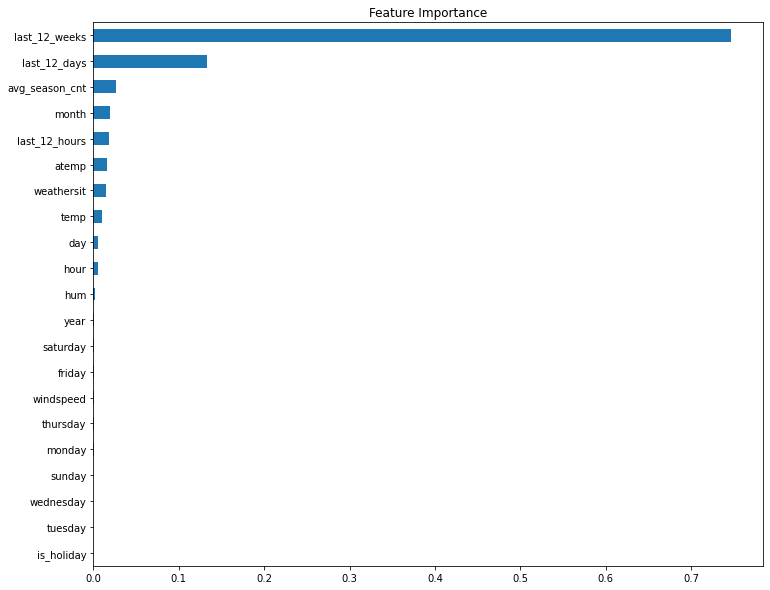

In [40]:
(
    pd.Series(rf.named_steps['model'].feature_importances_, 
              X.columns)
    .sort_values()

    .plot(kind='barh', figsize=(12,10), title='Feature Importance')
);

From here we can see that the top 11 features (up until `hum`) are the most important. We could use this to select just our top 10 features and see if that improves the model! But that's for the next chapter: Feature Selection!

<a id='types'></a>

## Types of feature engineering

Feature engineering is a way to isolate an highlight key information based on your own domain knowledge, which helps the algorithm focus on what's imporrtant. This is by far not an exhaustive list of the types of feature engineering that exist and the various 
* **Date and time features** Creating features from the dates available, e.g. is a holidays or day of the week. 
* **Group values** Grouping various numeric elements to a categorical variable, e.g. the months December (12), January (1) and February (2) to the season Winter. 
* **Grouping sparse classes** If you have a feature with an individual low sample count, you might group various values together under some other category. For example: if we had a column `bike_type` it would make sense to have stand-alone values such as `race`, `road` or `grandma`, whereas you might want to group values lik `penny farthing`, `unicycle` and `tricycle` together under a single `other` category since they are rarely rented.
* **Group from threshold** A new grouped variable for other variables, e.g. `warm` and `cold` based on the temperature.
* **Indicator from threshold** An indicator variable (0 or 1) based on a threshold on a column, e.g. eligible to vote based on age. 
* **Interaction of variables** The sum, difference, product or quotient of two features. E.g. `profit` as result of the difference between income and expenses. 

#### Adding external data
Part of feature engineering can also be to bring in external data. For example, let's say you're given a dataset for predicting house prices which contains the street address and city, and information about the house itself (e.g. number of rooms). Encoding the address information to longtitude and latitude by utilising a geocoding API allows you to bring in information from other external data sources about the neighborhood which might be predictive of the house price, such average income in the neighborhood, number of schools nearby, crime rate etc. 

#### Important
The goal of predictive modelling is often to create a model that can be used in practice. Although nothing is _technically_ holding us back from creating features based on future data (e.g. bike rental in the next 12 hours), in production, this would most likely not be available knowledge. In creating features, keep in mind what situation the data will be gathered and the model used. E.g. if the model to predict the number of bikes that will be rented will be used to allocate a number of bikes to rental locations which is used once a week will not have the number of bikes rented throughout that week available yet (and, for that matter, weather information). So make sure your model is not dependent on features not available when the model is used in practice! 

<a id='conclusion'></a>

## Conclusion

Feature engineering is the practice of constructing new features from existing data which may improve your model. The most important things to keep in mind are: 
* Feature engineering is typically a time-consuming process, but greatly beneficial to model performance
* Only create features that you have available at the time of data collection when the model is used in practice
* Feature engineering typically requires a lot of _domain knowledge_ to judge which features would be relevant to add

---
<img src='images/next.png' align='right' width=500px>
<a id='next'></a>

# What's next?

***In the training:***

- Feature Selection
- Object Oriented Programming in Scikit Learn - Making your own estimators/transformers
- Advanced Python 

***In the taster:***

- Want more? Sign up to our course!
    - [Advanced Data Science with Python](https://godatadriven.com/training/advanced-data-science-with-python-training/)
- Want something different? Look at what courses we offer!
    - [Python for Data Analysts](https://godatadriven.com/training/python-for-data-analysts-training/)
    - [Certified Python for Data Science](https://godatadriven.com/training/data-science-python-foundation-training/)
    - [And more!](https://godatadriven.com/what-we-do/train/#upcoming)
    
Interested in our other courses? Download our [Training Guide](https://godatadriven.com/topic/training-brochure/)"

Hope to see you soon!

---

### Downloading the Notebook:

<img src='images/download.png' width='80px' align='left'>

If you would like to there is a Download button at the top of the page. This will download the .ipynb

If you are not planning to get Anaconda but you want to save the work you've done, got to File -> Download as and choose .html.

<img src='images/visit.png' width='65px' align='left'>

Alternatively you can click Visit repo at the top to navigate to the github repo where you can download everything as a .zip file.